In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import warnings
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import keras
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from keras.applications.xception import Xception, preprocess_input
#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
print(os.listdir('../input/severstal-steel-defect-detection'))
from typeguard import typechecked
from typing import Optional

['sample_submission.csv', 'train_images', 'train.csv', 'test_images']


In [3]:
df = pd.read_csv("/kaggle/input/severstal-steel-defect-detection/train.csv")

In [4]:
df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [5]:
df.shape

(7095, 3)

In [6]:
df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [7]:
import pandas_profiling as pp
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

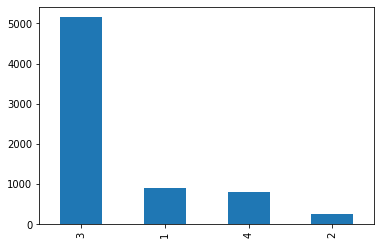

In [8]:
df["ClassId"].value_counts().plot(kind = 'bar')
df["ClassId"].value_counts()

In [9]:
df.shape

(7095, 3)

In [10]:
l1=[]
l2=[] 
for img,ClassId,EncodedPixels in tqdm(df.values):
    image=cv2.imread("/kaggle/input/severstal-steel-defect-detection/train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)


100%|██████████| 7095/7095 [01:31<00:00, 77.34it/s]


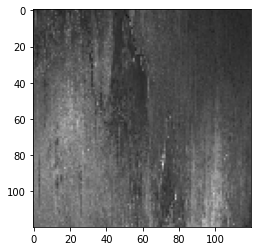

In [11]:
i = 3
plt.imshow(l1[i])


In [12]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = to_categorical(y)

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)
print("x_train shape:",X_train.shape)
print("x_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (5676, 120, 120, 3)
x_test shape: (1419, 120, 120, 3)
y_train shape: (5676, 4)
y_test shape: (1419, 4)


In [28]:
base_model = tf.keras.applications.densenet.DenseNet169(input_shape=(120,120,3),include_top=False,weights="imagenet")

51879936/51877672 [==============================] - 1s 0us/step


In [29]:
# Freezing Layers

for layer in base_model.layers[:-5]:
    layer.trainable=False


In [30]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
#model.add(Dense(64,activation="relu"))
#model.add(Dropout(0.3))



model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

In [31]:
# Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 3, 3, 1664)        12642880  
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 1664)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14976)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               3834112   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

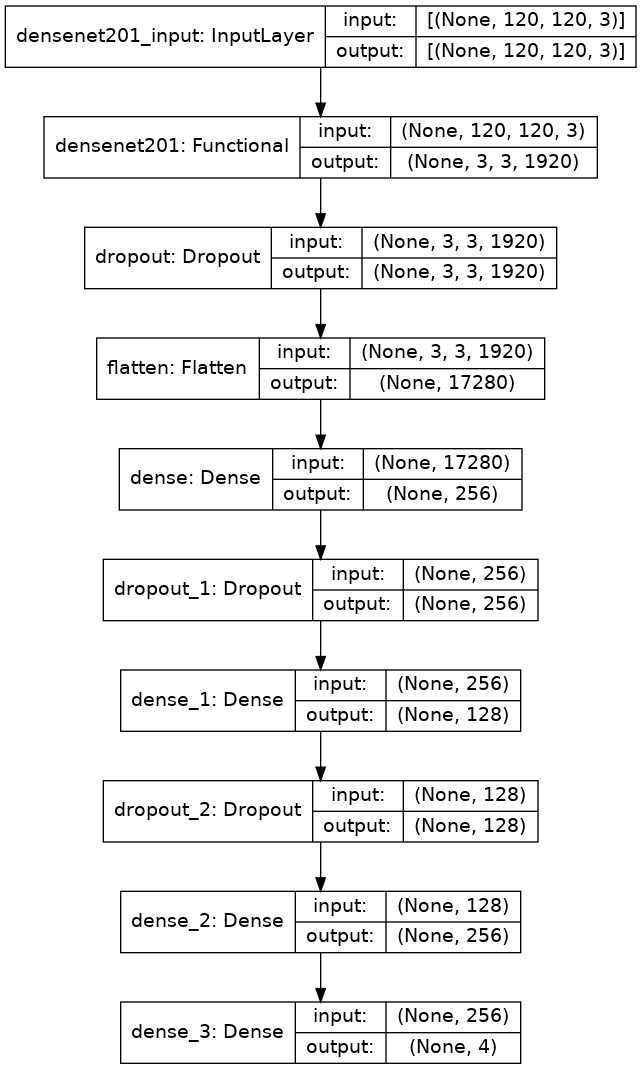

In [18]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [19]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [20]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
    dice_coef
]

In [22]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [32]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import callbacks
filepath="new15.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_precision',save_best_only=True, mode='max',verbose=1)
callbacks_list = [checkpoint]

In [34]:
%time
history15 = model.fit(X_train,y_train,epochs=150,validation_data=(X_test,y_test),batch_size=128,verbose=1,callbacks=[callbacks_list])

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
Epoch 1/150
45/45 [==============================] - 17s 184ms/step - loss: 1.1277 - accuracy: 0.8609 - precision: 0.7383 - recall: 0.6873 - auc: 0.8867 - f1_score: 0.6199 - dice_coef: 0.5610 - val_loss: 0.7349 - val_accuracy: 0.8582 - val_precision: 0.8936 - val_recall: 0.4912 - val_auc: 0.9483 - val_f1_score: 0.6253 - val_dice_coef: 0.5158

Epoch 00001: val_precision improved from -inf to 0.89359, saving model to new15.h5
Epoch 2/150
45/45 [==============================] - 5s 106ms/step - loss: 0.6324 - accuracy: 0.8747 - precision: 0.7728 - recall: 0.7063 - auc: 0.9297 - f1_score: 0.7379 - dice_coef: 0.6561 - val_loss: 0.5439 - val_accuracy: 0.9026 - val_precision: 0.8614 - val_recall: 0.7273 - val_auc: 0.9600 - val_f1_score: 0.7934 - val_dice_coef: 0.6397

Epoch 00002: val_precision did not improve from 0.89359
Epoch 3/150
45/45 [==============================] - 5s 102ms/step - loss: 0.5101 - accuracy: 0.8937 - p

In [26]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

NameError: name 'history' is not defined

In [35]:
Evaluate = model.evaluate(X_test, y_test)

45/45 [==============================] - 2s 32ms/step - loss: 0.9995 - accuracy: 0.9012 - precision: 0.8104 - recall: 0.7893 - auc: 0.9287 - f1_score: 0.7994 - dice_coef: 0.7918


In [ ]:
prediction = model.predict(X_test)

In [ ]:
prediction


In [ ]:
import numpy as np

In [ ]:
df_submission = pd.read_csv('../input/severstal-steel-defect-detection/sample_submission.csv')
print(df_submission.shape)
df_submission.head()

In [ ]:
df_submission.to_csv("submission.csv", index=False)
df_submission